This notebook runs on Colab using the GPU and High-RAM options.

BioFaceNet is a UNet coupled with model-based assumptions about camera and light that decomposes a face into parameter maps, primarily predicting melanin and haemoglobin content at any pixel in the face.

# Preamble

In [1]:
import os
import h5py
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms
!pip install kora --quiet
from kora import drive as koradrive
from google.colab import drive
drive.mount('/content/drive')
koradrive.chdir_notebook()
# Need to read utility data off the original MATLAB repo:
if not os.path.exists("BioFaces"):
  !git clone https://github.com/ssma502/BioFaces
# Dataset link from https://github.com/zhixinshu/NeuralFaceEditing
if not os.path.exists("NeuralFaceEditingDataset"):
  os.mkdir("NeuralFaceEditingDataset")
  os.chdir("NeuralFaceEditingDataset")
  !gdown --id 1LjXVghcSLk18JQxmu6iu2mYGaRveoYS3
  !gdown --id 1j0yWt0VJHDNZRTKHQnQo3nQLATvY0z-O
  !gdown --id 1KFn4TYsup0srjc0yAuYRPouA4mpTSUb2
  !gdown --id 1IbLNiPmi6UqBAZQC2dO2r5keljMCKpbn
  !gdown --id 1tBYPjV4D-SiMOONmF4fwmV5pD_XS4Ury
  !gdown --id 1BcMqUrAwDe2r0uTgdWyPYRZP6_KOVodO
  !gdown --id 1puzmuG_zA9u7FdNT3RUabLRmP9A-hHBd
  !gdown --id 1G4SHb3RJiv7coyeXBisU854sPIa0mbZ_
  !gdown --id 1LlH0XSO5a8PzaorOE66Shtk2MpqCYsKr
  !gdown --id 12EXVMH2Xs5qJIO618tFk7BF_6iK43uIG
  !gdown --id 1VzJyRmwVYX8c5DZd30CQmtXZdxZcf3vV
  !gdown --id 1MC4fCRDzoB58u3sQKi1X1t9AFHwFLKso
  !gdown --id 1t4j47DtLtKmyO7khhOqzXsc1ebtyYHlK
  !gdown --id 1aLPvtebfzXIqSypTNWQYCwy1TAjQLLMj
  !gdown --id 1ie9ucPvheNa6YyeMMDl4J1b1NTtrkn-H
  !gdown --id 18N4sYJcvU2A3hFmz1QYN9TV_bWu34XGh
  os.chdir("..")
# Copy dataset to local disk for faster access.
if not os.path.exists("/tmp/NeuralFaceEditingDataset"):
  os.makedirs("/tmp", exist_ok=True)
  !cp -r NeuralFaceEditingDataset /tmp/NeuralFaceEditingDataset
# ISET is for reproducing Table 1.
if not os.path.exists("ISET"):
  os.mkdir("ISET")
  os.chdir("ISET")
  !wget https://stacks.stanford.edu/file/druid:jj361kc0271/ISET_hiresfemale_1_4.zip
  !wget https://stacks.stanford.edu/file/druid:jj361kc0271/ISET_hiresfemale_5_8.zip
  !wget https://stacks.stanford.edu/file/druid:jj361kc0271/ISET_hiresfemale_9_13.zip
  !wget https://stacks.stanford.edu/file/druid:jj361kc0271/ISET_hiresmale_1_4.zip
  !wget https://stacks.stanford.edu/file/druid:jj361kc0271/ISET_hiresmale_5_8.zip
  !wget https://stacks.stanford.edu/file/druid:jj361kc0271/ISET_hiresmale_9_12.zip
  !wget https://stacks.stanford.edu/file/druid:jj361kc0271/montage.jpg
  !unzip '*.zip'
  os.chdir("..")
if not os.path.exists("/tmp/ISET"):
  os.makedirs("/tmp/ISET", exist_ok=True)
  !cp ISET/*.mat /tmp/ISET

     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CelebA Dataset and pseudo ground-truth shading computation

There was no code for how shading is computed; this is inferred from the [cited paper's](https://arxiv.org/pdf/1704.04131.pdf) equations (4) and (5) using their approximate spherical harmonic parameters. The dataset h5 files of the faces and spherical harmonic parameters extracted below are from [that same paper's repo](https://github.com/zhixinshu/NeuralFaceEditing).

The original CelebA dataset doesn't have these parameters so it's not possible to use it.

Notes:

- Since there are 3 sets of spherical harmonics for each sample, I assumed those are RGB and created an RGB-combined shading map, then made it grayscale. This resembles the shading maps in Fig 1e. of [the cited paper](https://arxiv.org/pdf/1704.04131.pdf). You can follow the `# Uncomment the line below to return RGB shading` prompt below, though keeping the shading RGB did not affect the results.

- The MATLAB repo raises each image to the power of 2.2, so we do the same. (again, not doing this did not affect the results).

In [2]:
class CelebADataset(torch.utils.data.Dataset):
  def __init__(self, dataset_root_path="NeuralFaceEditingDataset", small=False):
    self.small = small
    self.image_tensor, self.light_tensor = self._read_dataset(dataset_root_path)

  def _read_dataset(self, dataset_root_path):
    """
    Read the files of NeuralFaceEditingDataset, validate their properties, and combine them into a single dataset
    """
    files = [f for f in os.listdir(dataset_root_path)]
    image_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in sorted(os.listdir(dataset_root_path)) if "inmc_celebA" in f]
    light_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in sorted(os.listdir(dataset_root_path)) if "lrgb_celebA" in f]
    assert len(image_files) == len(light_files), "number of image hdf5 files and the number of light hdf5 files mismatch"
    image_tensors = [h5py.File(os.path.join(dataset_root_path, image_file), 'r')["zx_7"] for image_file in image_files]
    light_tensors = [h5py.File(os.path.join(dataset_root_path, light_file), 'r')["zx_7"] for light_file in light_files]
    for image_tensor, light_tensor in zip(image_tensors, light_tensors):
      assert image_tensor.shape[0] == light_tensor.shape[0], "image/light file pair doesn't have the same number of samples"
      assert image_tensor.shape[1] == 10, "image data doesn't have 10 channels"
      assert tuple(light_tensor.shape[-2:]) == (3, 9), "light harmonics data is not in expected shape of (3,9)"
    image_tensor = self._concatenate_h5py_datasets(image_files, "zx_7", "/content/imagedata.h5")
    light_tensor = self._concatenate_h5py_datasets(light_files, "zx_7", "/content/lightdata.h5")
    assert np.equal(image_tensor[image_tensors[0].shape[0]], image_tensors[1][0]).all(), "first frame of second tensor is not properly positioned in the combined dataset"
    assert np.equal(image_tensor[-1], image_tensors[-1][-1]).all(), "last image is not properly positioned in the combined dataset"
    assert image_tensor.shape[0] == light_tensor.shape[0], "the image and light tensors do not have 1 to 1 sample correspondence"
    return image_tensor, light_tensor
  
  # adapted from official h5py examples
  def _concatenate_h5py_datasets(self, file_paths_to_concatenate, entry_key, destination_path):
    """
    Combines h5py files of shape (a,x,y,z), (b,x,y,z), (c,x,y,z) into (a+b+c,x,y,z) and returns the tensor pointer.
    """
    number_of_samples = [h5py.File(f, 'r')[entry_key].shape[0] for f in file_paths_to_concatenate]
    total_number_of_samples = sum(number_of_samples)
    sample_shape = h5py.File(file_paths_to_concatenate[0], 'r')[entry_key].shape[1:] # shape of a single sample
    layout = h5py.VirtualLayout(shape=(total_number_of_samples,) + sample_shape, dtype=np.float64)

    ptr = 0
    for i, source_file_name in enumerate(file_paths_to_concatenate):
      vsource = h5py.VirtualSource(source_file_name, entry_key, shape=(number_of_samples[i],) + sample_shape)
      layout[ptr:ptr+number_of_samples[i]] = vsource
      ptr += number_of_samples[i]
    assert ptr == total_number_of_samples, "dataset not combined properly"

    if os.path.exists(destination_path):
      os.remove(destination_path)
    with h5py.File(destination_path, 'w', libver='latest') as destination_file:
      destination_file.create_virtual_dataset(entry_key, layout)

    return h5py.File(destination_path, 'r')[entry_key]
  
  def _compute_shading(self, normal, light):
    """
    normal: (3, H, W)
    light: (3, 9)
    """
    from skimage import color
    augmented_normal = np.concatenate([normal, np.ones_like(normal[0][np.newaxis, ...])], axis=0) # (4, 64, 64)
    augmented_normal_transposed = np.moveaxis(augmented_normal, 0, -1) # (64, 64, 4)
    shading_responses = []
    for L in light: # compute shading across red, green, blue
      c1, c2, c3, c4, c5 = 0.429043, 0.511664, 0.743125, 0.886227, 0.247708
      K = np.array([[c1*L[8], c1*L[4], c1*L[7], c2*L[3]],
                    [c1*L[4], -c1*L[8], c1*L[5], c2*L[1]],
                    [c1*L[7], c1*L[5], c3*L[6], c2*L[2]],
                    [c2*L[3], c2*L[1], c2*L[2], c4*L[0] - c5*L[6]]])
      # ((64, 64, 4) @ (4, 4)) * (64, 64, 4)
      shading_response = np.sum((augmented_normal_transposed @ K) * augmented_normal_transposed, axis=-1)
      # pass shading through ReLU because it must be nonnegative
      shading_responses.append(np.maximum(shading_response, 0))
    # Uncomment the line below to return RGB shading
    # return np.array(shading_responses)
    # turn shading into grayscale
    return np.moveaxis(color.rgb2gray(np.moveaxis(np.array(shading_responses), 0, -1)), -1, 0)

  def __len__(self):
    return 2 if self.small else self.image_tensor.shape[0]

  def __getitem__(self, idx):
    # original code raises images to the power of 2.2.
    # subtract the average CelebA pixels just like the MATLAB repo.
    image = (255 * (self.image_tensor[idx][:3]**2.2)) - np.array([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) # (3, H, W)
    normal = self.image_tensor[idx][3:6] # (3, H, W)
    mask = self.image_tensor[idx][6][np.newaxis,...] # (1, H, W)
    coord = self.image_tensor[idx][7:] # (3, H, W)
    light = self.light_tensor[idx] # (3, 9)
    shading = self._compute_shading(normal, light) # (H, W)
    return {"image": image, "normal": normal, "mask": mask, "shading": shading, "light": light}

def displayCelebASample(sampleNo):
  item = CelebADataset(dataset_root_path="/tmp/NeuralFaceEditingDataset")[sampleNo]
  print(item["image"].shape, item["normal"].shape, item["mask"].shape, item["shading"].shape, item["light"].shape)
  plt.imshow(np.moveaxis((item["image"] + np.array([129.1863,104.7624,93.5940]).reshape((3, 1, 1)))/255, 0, -1))
  plt.figure()
  plt.imshow(np.moveaxis(item["shading"], 0, -1), cmap='gray')
  plt.figure()
  plt.imshow(item["mask"].squeeze(0), cmap='gray')
  print(item["image"].min(), item["image"].max())

In Sample #15 below, the shading plot has wider lips than the original color image where the mouth is slightly open, probably due to overfitting the CelebA dataset where celebrities are predominantly smiling and that's what the network learned in the *Neural Face Editing with Intrinsic Image Disentangling* paper. This case is common whenever the subject isn't smiling or has an open mouth, e.g. sample #340 (see below). Sometimes the nose size is rendered differently e.g. sample #300 (see below). This may hint at a dataset bias that potentially affects convergence.

(3, 64, 64) (3, 64, 64) (1, 64, 64) (64, 64) (3, 9)
-123.84376136173081 114.32686026292585


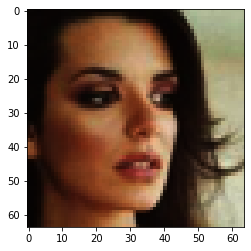

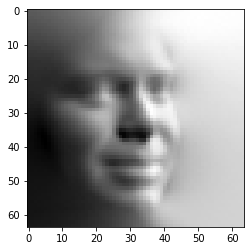

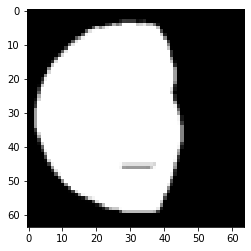

In [3]:
displayCelebASample(15)

(3, 64, 64) (3, 64, 64) (1, 64, 64) (64, 64) (3, 9)
-129.1863 161.406


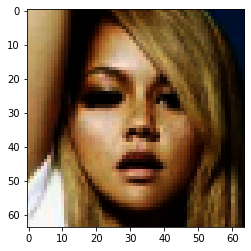

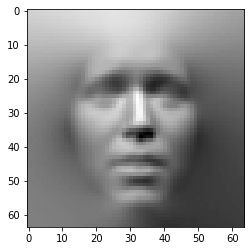

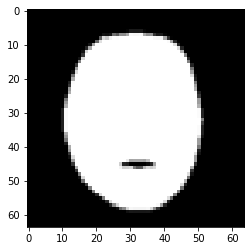

In [4]:
displayCelebASample(340)

(3, 64, 64) (3, 64, 64) (1, 64, 64) (64, 64) (3, 9)
-127.64594861801334 106.43200048922756


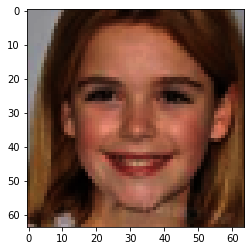

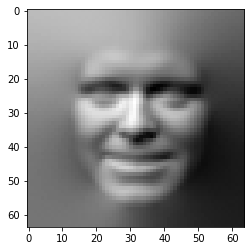

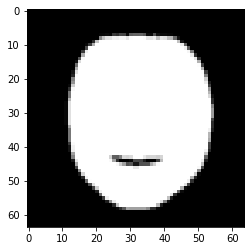

In [5]:
displayCelebASample(300)

This function calculates the camera parameters using PCA. The eigenvalues calculated by `sklearn.decomposition.PCA` are off by a negligible amount compared to those obtained by `pca` in MATLAB. Plus, we only use the top two components of the eigendecomposition. Saving the
`PC, mu, EV` matrices from MATLAB and loading them directly here (as opposed to running `camera_sensitivity_pca`) did not affect the results (code that directly loads MATLAB-produced `PC, mu, EV` is commented out below).

In [6]:
def camera_sensitivity_pca(camera_matrix, wavelength=33):
  from sklearn.decomposition import PCA
  # camera_matrix is shape (3, 33, 28)
  camera_matrix = np.moveaxis(camera_matrix, 1, -1) # (3, 28, 33)
  # normalize the channels: (3, 28, 33) / (3, 28, 1)
  camera_matrix /= np.sum(camera_matrix, axis=-1)[..., np.newaxis]
  camera_matrix = np.moveaxis(camera_matrix, -1, 1).reshape((wavelength*3, -1)).T # (3, 33, 28) -> (99, 28) -> (28, 99)

  mu = np.mean(camera_matrix, axis=0) # (99,)
  pca = PCA(n_components=camera_matrix.shape[0]-1 if camera_matrix.shape[0]-1 <= 3*wavelength else camera_matrix.shape[1])
  score = pca.fit_transform(camera_matrix) # (28, 27) = 99 dimensions reduced to 27
  PC = pca.components_ # (27, 99) = linear weights of reduced features based on original features
  # Eigenvalues aren't the same as the MATLAB one but pretty close after applying normalization fix from https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
  camera_matrix -= np.mean(camera_matrix, axis=0)
  cov_matrix = np.dot(camera_matrix.T, camera_matrix) / camera_matrix.shape[0]
  EV = np.array([np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)) for eigenvector in PC]) # these EVs are already sorted in descending order.
  # EV, _ = np.linalg.eig(cov_matrix) # another way to calculate eigenvalues.
  print(len(EV), EV)
  PC = PC[:2,:].T @ np.diag(np.sqrt(EV[:2])) # take the first two components
  print(PC.shape, mu.shape, EV.shape)
  return PC, mu, EV[:2]

PC, mu, EV = camera_sensitivity_pca(np.array(list(scipy.io.loadmat("BioFaces/util/rgbCMF.mat")["rgbCMF"][0])))
# Uncomment the line below to load results that MATLAB's pca produced as opposed to running sklearn.decomposition.PCA in camera_sensitivity_pca (requires PC.mat, mu.mat, EV.mat)
# PC, mu, EV = scipy.io.loadmat("PC.mat")["PC"], scipy.io.loadmat("mu.mat")["mu"].flatten(), scipy.io.loadmat("EV.mat")["EV"].flatten()
print(PC.shape, mu.shape, EV.shape)

27 [2.12113213e-03 2.03365795e-03 8.91491402e-04 6.02606753e-04
 5.48655565e-04 3.10893752e-04 2.46156176e-04 2.39692698e-04
 1.45694845e-04 1.14032461e-04 8.16822969e-05 5.73456412e-05
 5.43734803e-05 3.47104898e-05 2.90255075e-05 1.92062816e-05
 1.63463782e-05 1.05204652e-05 9.44638737e-06 9.30503849e-06
 6.61023527e-06 3.10903962e-06 2.95937828e-06 2.12892015e-06
 1.42862627e-06 9.33871203e-07 6.52544624e-07]
(99, 2) (99,) (27,)
(99, 2) (99,) (2,)


# UNet

This is the UNet implementation with 1 encoder and 4 decoders, one decoder for each one of melanin, haemoglobin, shading, and specularities.

### Notes:

- What the paper and the MATLAB comments refer to as "fully-connected layers" is in fact, 1x1 convolutions (see `self.light_and_b_layer` below) in the actual MATLAB code; thus, that's how it's implemented here. This may not have a huge impact as the depth of the input tensor at that layer is much bigger than the height and width (i.e. connectivity is still very high).

- The MATLAB comments claim a height and width of 224x224 for the melanin, haemoglobin, shading, and specularity maps; however, our CelebA dataset has an input shape of 64x64. The authors may have used a different dataset or recomputed the dataset from the paper they cited. Meanwhile, BioFaceNet authors mention using a 50k subset of CelebA and the precomputed dataset of the paper they cited (which is the one we're using) also has 50k samples from CelebA.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNet(nn.Module):

  def __init__(self, filters, light_vector_size=15, n_class=4, b_size=2, add_double_conv=True, copy_shading=False):
    super(UNet, self).__init__()
    filters = [3] + filters # filter sizes to apply. [3] is the first in_channels which is always 3 because the input is RGB.
    self.copy_shading = copy_shading # instead of learning a shading map, it copies the B&W image (used for diagnostics)
    self.filters = filters
    self.light_vector_size = light_vector_size
    self.b_size = b_size
    self.n_class = n_class
    self.base = lambda in_channels, out_channels: nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(out_channels, eps=1e-04), # eps to meet MATLAB's batchnorm.
      nn.ReLU()
    )
    self.extra_conv = lambda channels: nn.Sequential(        
      nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(channels, eps=1e-04),
      nn.ReLU()
    )
    self.light_and_b_layer = nn.Sequential(
      nn.Conv2d(filters[-1], filters[-1], kernel_size=(4,4)),
      nn.BatchNorm2d(filters[-1], eps=1e-04),
      nn.ReLU(),
      nn.Conv2d(filters[-1], filters[-1], kernel_size=(1,1)),
      nn.BatchNorm2d(filters[-1], eps=1e-04),
      nn.ReLU(),
      nn.Conv2d(filters[-1], light_vector_size+b_size, kernel_size=(1, 1))
    )
    
    # Encoder layers
    self.encoder_layers = []
    for i in range(1, len(filters)):
      layer = nn.Sequential(self.base(filters[i-1], filters[i]), self.extra_conv(filters[i]), self.extra_conv(filters[i])) if add_double_conv else self.base(filters[i-1], filters[i])
      self.encoder_layers.append(layer)
    
    # Decoder layers
    self.decoder_layers_by_class = []
    for i in range(n_class):
      decoder_layers = [nn.Conv2d(self.filters[1], 1, kernel_size=(3, 3), padding=1)]
      for i in range(1, len(filters)-1): # start from 1 in order to exclude the [3] we prepended.
        layer = nn.Sequential(self.base(filters[i]+filters[i+1], filters[i]), self.extra_conv(filters[i]), self.extra_conv(filters[i])) if add_double_conv else self.base(filters[i]+filters[i+1], filters[i])
        decoder_layers.append(layer)
      self.decoder_layers_by_class.append(decoder_layers)
  
  # MATLAB file says f_mel, f_blood, shading, spec_mask should be 224 x 224 but yours is 64 x 64
  def scale_f_mel(self, f_mel):
    return torch.sigmoid(f_mel) * 2 - 1
  
  def scale_f_blood(self, f_blood):
    return torch.sigmoid(f_blood) * 2 - 1
  
  def scale_shading(self, shading):
    return torch.exp(shading)

  def scale_spec_mask(self, spec_mask):
    return torch.exp(spec_mask)

  def scale_b(self, b):
    return 6 * torch.sigmoid(b) - 3 

  def get_b_grid(self, scaled_b):
    return scaled_b.reshape(-1, self.b_size, 1, 1) / 3
  
  def get_lighting_weights(self, lighting_parameters):
    cct = lighting_parameters[:,14]
    lighting_weights = F.softmax(lighting_parameters[:,:14], dim=1)
    weight_a = lighting_weights[:,0]
    weight_d = lighting_weights[:,1]
    f_weights = lighting_weights[:,2:14]
    cct = ((22-1) / (1 + torch.exp(-cct))) # removed +1 since it's used as an indexer. it's now between [0-21].
    return weight_a, weight_d, f_weights, cct

  def forward(self, x_original):
    # Encode
    x = x_original
    x_skip = []
    for i in range(1, len(self.filters)):
      x = self.encoder_layers[i-1](x)
      if i != len(self.filters)-1:
        x_skip.append(x)
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=2)
    y = x


    # Decode
    predictions = []
    for c in range(self.n_class):
      # print("----class----")
      for i in range(len(self.filters)-2, -1, -1):
          if i > 0:
            x = F.interpolate(y if i == len(self.filters)-2 else x, scale_factor=2, mode='bilinear', align_corners=True)
            x = torch.cat([x, x_skip[i-1]], dim=1)
          x = self.decoder_layers_by_class[c][i](x)
      predictions.append(x)
    f_mel, f_blood, shading, spec_mask = predictions

    if self.copy_shading:
      shading = torchvision.transforms.Grayscale()(x_original) / 255

    # Fully connected layers? (that's what they call it in the MATLAB repo)
    light_and_b_prediction = self.light_and_b_layer(y)
    light_prediction = light_and_b_prediction[:,:self.light_vector_size,...]
    b_prediction = light_and_b_prediction[:,self.light_vector_size:,...]

    weight_a, weight_d, f_weights, cct = self.get_lighting_weights(light_prediction.squeeze(-1).squeeze(-1))
    b_prediction = b_prediction.squeeze(-1).squeeze(-1)
    scaled_b_prediction = self.scale_b(b_prediction)
    b_grid = self.get_b_grid(scaled_b_prediction)

    return {
      "light_prediction": light_prediction,
      "b_prediction": scaled_b_prediction,
      "b_grid": b_grid,
      "weight_a": weight_a, "weight_d": weight_d, "f_weights": f_weights, "cct": cct,
      "f_mel": self.scale_f_mel(f_mel), "f_blood": self.scale_f_blood(f_blood), "predicted_shading": self.scale_shading(shading), "spec_mask": self.scale_spec_mask(spec_mask)
    }

def unet_test():
  x = torch.FloatTensor(16, 3, 64, 64)
  model = UNet(filters=[32, 64, 128, 256, 512])
  print([(key, value.shape) for key, value in model(x).items()])

unet_test()

[('light_prediction', torch.Size([16, 15, 1, 1])), ('b_prediction', torch.Size([16, 2])), ('b_grid', torch.Size([16, 2, 1, 1])), ('weight_a', torch.Size([16])), ('weight_d', torch.Size([16])), ('f_weights', torch.Size([16, 12])), ('cct', torch.Size([16])), ('f_mel', torch.Size([16, 1, 64, 64])), ('f_blood', torch.Size([16, 1, 64, 64])), ('predicted_shading', torch.Size([16, 1, 64, 64])), ('spec_mask', torch.Size([16, 1, 64, 64]))]


# Light model

This is the light and camera models that reconstruct the image from the UNet-learned parameters. It follows the original MATLAB repo of the authors. The function `perform_decoding_pipeline` below summarizes the reconstruction steps.

## Notes:

- The function `vl_nnillumD` is used in the repo but not implemented in the repo or the MatConvNet docs. Based on the paper's explanation and the shape of the `illum_d_norm` array, I conclude that `illum_d_norm` encodes Illuminant D for each color temperature within 4000-25000K at 1K intervals and 33 wavelength discretizations at each interval because the shape of `illum_d_norm` is (33, 22). Thus, `cct` must be the parameter that chooses the appropriate color temperature from `illum_d_norm`. I round `cct` to the nearest integer to facilitate indexing, but a better way might have been to linearly interpolate between two color temperatures when `cct` is between two temperature intervals. Since we don't know what `vl_nnillumD` actually does and torch's `grid_sample` doesn't readily support interpolating along a single dimension, I did not make this assumption.



In [8]:
def illumination_model(weight_a, weight_d, f_weights, cct, illum_a, illum_d_norm, illum_f_norm):
  illuminant_a = illum_a * weight_a.unsqueeze(-1) # (B, 33) * (B, 1) -> (B, 33)
  # cannot determine from the paper how to use cct (B) with illumDnorm to calculate illuminant_d.
  # since there are 22 illum_d_norms and color temperature ranges in 4K to 25K, illum_d_norm may be indexed by the nearest K
  # instead of rounding, another idea is to interpolate.
  illuminant_d = (illum_d_norm[:,torch.round(cct).long()] * weight_d).permute(1, 0) # (33, 22[sel B]) (B) -> (33, B) -> (B, 33)
  # illum_f_norm: (33, 12) * f_weights: (B, 12) -> (B, 33, 12)
  illuminant_f = torch.stack([illum_f_norm * f_weight for f_weight in f_weights])
  illuminant_f = torch.sum(illuminant_f, dim=2) # (B, 33)
  e = illuminant_a + illuminant_d + illuminant_f # (B, 33)
  e /= torch.sum(e, dim=0) # (B, 33) / (33) -> (B, 33)
  assert (e > 0).all()
  return e

def camera_model(mu, PC, b, wavelength):
  """
  PC: (99, 2) 
  mu: (99,)
  b: (B, 2)
  wavelength = 33
  """
  s = b @ PC.T + mu # (B, 2) @ (2, 99) + (99,) -> (B, 99)
  s = F.relu(s)
  s_r, s_g, s_b = s[:,:wavelength], s[:,wavelength:2*wavelength], s[:,2*wavelength:]
  return s_r, s_g, s_b # (B, 33) ea.

def compute_light_color(e, s_r, s_g, s_b):
  light_color = torch.stack([torch.sum(s_r * e, dim=1), torch.sum(s_g * e, dim=1), torch.sum(s_b * e, dim=1)], dim=1)
  return light_color # (B, 3)

def compute_specularities(spec_mask, light_color):
  # inputs: (B, 1, H, W), (B, 3)
  return spec_mask * light_color.unsqueeze(-1).unsqueeze(-1)

def bio_to_spectral_ref(f_mel, f_blood, new_skin_color):
  import torch.nn.functional as F
  """
  f_mel             : B, 1, H, W
  f_blood           : B, 1, H, W
  new_skin_color    : B, 33, 256, 256
  """
  biophysical_maps = torch.cat((f_mel, f_blood), dim=1).permute(0,2,3,1) # (b,2,h,w) -> (b,h,w,2)
  # Uncomment the line below if f_mel and f_blood are flipped, since grid_sample's docs don't explain if the grid is x,y or y,x ordered.
  # biophysical_maps[..., 0], biophysical_maps[..., 1] = biophysical_maps[..., 1], biophysical_maps[..., 0]
  
  r_total = F.grid_sample(input=new_skin_color, grid=biophysical_maps)
  return r_total # (B, 33, H, W)

def image_formation(r_total, s_r, s_g, s_b, e, specularities, shading):
  # srgb: (B, 33) ea.
  # r_total: (B, 33, H, W)
  # e: (B, 33)
  # specularities: (B, C, H, W) where C is 1 or 3.
  # shading: (B, 1, H, W)
  spectra_ref = r_total * e.unsqueeze(-1).unsqueeze(-1) # (B, 33, H, W) * (B, 33)
  r_channel = torch.sum(spectra_ref * s_r.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True) # (B, 33, H, W) * (B, 33) sum -> (B, 1, H, W)
  g_channel = torch.sum(spectra_ref * s_g.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True)
  b_channel = torch.sum(spectra_ref * s_b.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True)
  diffuse_albedo = torch.cat([r_channel, g_channel, b_channel], dim=1) # (B, 3, H, W)
  shaded_diffuse = diffuse_albedo * shading # (B, 3, H, W) * (B, 1, H, W) -> (B, 3, H, W)
  # diag(e) i_d r + diag(e) i_s
  raw_appearance = shaded_diffuse + specularities
  return raw_appearance, diffuse_albedo

def white_balance(raw_appearance, light_color):
  image_white_balanced = raw_appearance / light_color.unsqueeze(-1).unsqueeze(-1) # (B, 3, H, W) / (B, 3, 1, 1)
  return image_white_balanced # (B, 3, H, W)

def find_t(t_matrix, b_grid):
  # t_matrix: (B, 128, 128, 9) -> (B, 9, 128, 128) as (N, C, H_old, W_old)
  # b_grid: (B, 2, 1, 1) -> (B, 1, 1, 2) as (N, H_new, W_new, 2)
  # t_raw2xyz: (B, 9, 1, 1) as (N, C, H_new, W_new)
  t_raw2xyz = F.grid_sample(input=torch.moveaxis(t_matrix, -1, 1), 
                            grid=torch.moveaxis(b_grid, 1, -1))
  return t_raw2xyz

def from_raw_to_srgb(image_white_balanced, t_raw2xyz):
  # image_white_balanced: (B, 3, H, W)
  # t_raw2xyz: (B, 9, 1, 1)
  image_x = t_raw2xyz[:,0] * image_white_balanced[:,0] + t_raw2xyz[:,3] * image_white_balanced[:,1] + t_raw2xyz[:,6] * image_white_balanced[:,2] # (B, H, W)
  image_y = t_raw2xyz[:,1] * image_white_balanced[:,0] + t_raw2xyz[:,4] * image_white_balanced[:,1] + t_raw2xyz[:,7] * image_white_balanced[:,2]
  image_z = t_raw2xyz[:,2] * image_white_balanced[:,0] + t_raw2xyz[:,5] * image_white_balanced[:,1] + t_raw2xyz[:,8] * image_white_balanced[:,2]
  image_xyz = torch.stack([image_x, image_y, image_z], dim=1) # (B, 3, H, W)
  t_xyz_rgb = torch.FloatTensor([3.2406, -0.9689, 0.0557, -1.5372, 1.8758, -0.2040, -0.4986, 0.0415, 1.057])
  r = t_xyz_rgb[0] * image_xyz[:,0] + t_xyz_rgb[3] * image_xyz[:,1] + t_xyz_rgb[6] * image_xyz[:,2] # (B, H, W) * (1,) -> (B, H, W)
  g = t_xyz_rgb[1] * image_xyz[:,0] + t_xyz_rgb[4] * image_xyz[:,1] + t_xyz_rgb[7] * image_xyz[:,2]
  b = t_xyz_rgb[2] * image_xyz[:,0] + t_xyz_rgb[5] * image_xyz[:,1] + t_xyz_rgb[8] * image_xyz[:,2]
  s_rgb_image = torch.stack([r, g, b], dim=1) # (B, 3, H, W)
  return F.relu(s_rgb_image)

def perform_decoding_pipeline(parameters, illum_a, illum_d_norm, illum_f_norm, PC, mu, EV, wavelength, new_skin_color, t_matrix):
  weight_a, weight_d, f_weights, cct, b_prediction, b_grid, f_mel, f_blood, predicted_shading, spec_mask, light_prediction = parameters["weight_a"], parameters["weight_d"], parameters["f_weights"], parameters["cct"], parameters["b_prediction"], parameters["b_grid"], parameters["f_mel"], parameters["f_blood"], parameters["predicted_shading"], parameters["spec_mask"], parameters["light_prediction"]
  e = illumination_model(weight_a, weight_d, f_weights, cct, illum_a, illum_d_norm, illum_f_norm)
  s_r, s_g, s_b = camera_model(mu, PC, b_prediction, wavelength)
  light_color = compute_light_color(e, s_r, s_g, s_b)
  specularities = compute_specularities(spec_mask, light_color)
  r_total = bio_to_spectral_ref(f_mel, f_blood, new_skin_color)
  raw_appearance, diffuse_albedo = image_formation(r_total, s_r, s_g, s_b, e, specularities, predicted_shading)
  image_white_balanced = white_balance(raw_appearance, light_color)
  t_raw2xyz = find_t(t_matrix, b_grid)
  s_rgb_image = from_raw_to_srgb(image_white_balanced, t_raw2xyz)
  return s_rgb_image, predicted_shading, specularities, b_prediction, diffuse_albedo

def compute_loss(original, reconstructed, predicted_shading, actual_shading, actual_masks, specularities, b_prediction):
  # (16, 3, 1, 1) due to ((16, 3, 256, 256) * (16, 1, 256, 256) -> (16, 3, 1, 1)) / ((16, 1, 256,256)**2 -> (16, 1, 1, 1))
  scale = torch.sum(actual_shading * predicted_shading * actual_masks, dim=(-1, -2), keepdim=True) / torch.sum(predicted_shading * predicted_shading * actual_masks, dim=(-1, -2), keepdim=True)
  # (16, 1, 256, 256) due to (16, 1, 256, 256) * (16, 1, 1, 1)
  predicted_shading = predicted_shading * scale
  # (16, 3, 256, 256)
  alpha = (actual_shading - predicted_shading) * actual_masks
  # print("shading diff:", alpha.min(), alpha.max())
  appearance_weight, b_loss_weight, shading_weight, sparse_weight = 1e-3, 1e-4, 1e-5, 1e-5
  delta = (original - reconstructed) * actual_masks
  # print("image diff:", delta.min(), delta.max())
  appearance_loss = appearance_weight * torch.sum(delta**2) / (original.shape[-1] * original.shape[-2])
  b_loss = b_loss_weight * torch.sum(b_prediction**2)
  shading_loss = shading_weight * torch.sum(alpha**2)
  sparsity_loss = sparse_weight * torch.sum(specularities)
  return b_loss, appearance_loss, shading_loss, sparsity_loss

# Train and visualize to reproduce Figure 1

In [9]:
small_dataset = True # used for overfitting a small number of images; set to False for 60/20/20 split on 50k images.
learning_rate = 1e-5 # MATLAB repo says 1e-5
batch_size = 2 if small_dataset else 64 # MATLAB repo chooses 64, but we are overfitting a small dataset below.
illum_a, illum_d_measured, illum_f, new_skin_color, t_matrix = np.tile(scipy.io.loadmat("BioFaces/util/illumA.mat")["illumA"], (batch_size,1,1)).squeeze(), scipy.io.loadmat("BioFaces/util/illumDmeasured.mat")["illumDmeasured"].reshape(1, 1, 33, 22), scipy.io.loadmat("BioFaces/util/illF.mat")["illF"].reshape(1, 1, 33, 12), np.tile(np.moveaxis(scipy.io.loadmat("BioFaces/util/Newskincolour.mat")["Newskincolour"], -1, 0), (batch_size, 1, 1, 1)), np.tile(scipy.io.loadmat("BioFaces/util/Tmatrix.mat")["Tmatrix"][np.newaxis,...], (batch_size, 1, 1, 1))
illum_a /= np.sum(illum_a)
illum_d_norm = (illum_d_measured / illum_d_measured.sum(axis=-1, keepdims=True)).squeeze()
illum_f_norm = (illum_f / illum_f.sum(axis=-1, keepdims=True)).squeeze()
illum_a, illum_d_norm, illum_f_norm, new_skin_color, t_matrix = torch.from_numpy(illum_a), torch.from_numpy(illum_d_norm), torch.from_numpy(illum_f_norm), torch.from_numpy(new_skin_color), torch.from_numpy(t_matrix)
PC, mu, EV = camera_sensitivity_pca(np.array(list(scipy.io.loadmat("BioFaces/util/rgbCMF.mat")["rgbCMF"][0])))
# PC, mu, EV = torch.from_numpy(scipy.io.loadmat("PC.mat")["PC"]).float(), torch.from_numpy(scipy.io.loadmat("mu.mat")["mu"].flatten()).float(), torch.from_numpy(scipy.io.loadmat("EV.mat")["EV"].flatten()).float()
PC, mu, EV = torch.from_numpy(PC).float(), torch.from_numpy(mu).float(), torch.from_numpy(EV).float()
wavelength = 33

dataset = CelebADataset(dataset_root_path="/tmp/NeuralFaceEditingDataset", small=small_dataset)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def display_images(original_image, s_rgb_image, predicted_shading, specularities, f_mel, f_blood, diffuse_albedo, actual_masks):
  from matplotlib import pyplot as plt
  # s_rgb_image: (B, 3, H, W), predicted_shading: (B, 1, H, W), specularities: (B, 3, H, W), diffuse_albedo: (B, 3, H, W)
  images_to_display = list(range(0, min(4, original_image.shape[0])))
  for i in images_to_display:
    plt.figure()
    plt.subplot(1, 7, 1)
    # print(f"original min/max {(original_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actual_masks[i]).min()} {(original_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actual_masks[i]).max()}")
    plt.imshow(np.moveaxis(((original_image[i] + torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) )/255*actual_masks[i]).cpu().detach().numpy().astype(float), 0, -1))
    plt.subplot(1, 7, 2)
    # print(f"reconstruction min/max {(s_rgb_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actual_masks[i]).min()} {(s_rgb_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actual_masks[i]).max()}")
    plt.imshow(np.moveaxis(( (s_rgb_image[i] + torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) )/255*actual_masks[i]).cpu().detach().numpy().astype(float), 0, -1))
    plt.subplot(1, 7, 3)
    plt.imshow((predicted_shading[i]*actual_masks[i]).squeeze(0).cpu().detach().numpy(), cmap='gray')
    plt.subplot(1, 7, 4)
    specularity = np.moveaxis((specularities[i]*actual_masks[i]).cpu().detach().numpy(), 0, -1)
    plt.imshow(specularity / specularity.max())
    plt.subplot(1, 7, 5)
    plt.imshow((f_mel[i]).squeeze(0).cpu().detach().numpy(), vmin=-1, vmax=1)
    plt.subplot(1, 7, 6)
    plt.imshow((f_blood[i]).squeeze(0).cpu().detach().numpy(), vmin=-1, vmax=1)
    plt.subplot(1, 7, 7)
    plottable_diffuse_albedo = np.moveaxis((diffuse_albedo[i]*actual_masks[i]).cpu().detach().numpy(), 0, -1)
    plt.imshow(plottable_diffuse_albedo / plottable_diffuse_albedo.max())
    plt.show()


def make_train_val_test_dataloaders(dataset, batch_size):
  from torch.utils.data.sampler import SubsetRandomSampler
  # Could not find dataset split in the experiment section; assuming 60/20/20 split.
  np.random.seed(seed=42)
  all_samples, train_size, val_size = [i for i in range(len(dataset))], (1.0 if small_dataset else 0.6), (0.0 if small_dataset else 0.2)
  np.random.shuffle(all_samples)
  train_samples, val_samples, test_samples = np.split(all_samples, 
                                                        [int(train_size * len(all_samples)), 
                                                        int((train_size + val_size) * len(all_samples))
                                                        ])
  dataloaders = {
      "train": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_samples), pin_memory=True, drop_last=True),
      "val": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_samples), pin_memory=True, drop_last=True),
      "test": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_samples), pin_memory=True, drop_last=True),
  }
  return dataloaders

dataloaders = make_train_val_test_dataloaders(dataset, batch_size)

def train_model(model, dataloaders, optimizers, output_path, device, num_epochs=2000, epoch_start=0, display_condition=None):
  for epoch in range(epoch_start, num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    
    for phase in ["train", "val"]:
      running_loss, running_b_loss, running_app_loss, running_shading_loss, running_sparsity_loss = 0, 0, 0, 0, 0
      if phase == "train": model.train()
      else: model.eval()

      epoch_size = 0
      for i, batch in enumerate(dataloaders[phase]):
        for optimizer in optimizers: optimizer.zero_grad()
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(batch["image"].float())
          s_rgb_image, predicted_shading, specularities, b_prediction, diffuse_albedo = perform_decoding_pipeline(outputs, illum_a, illum_d_norm, illum_f_norm, PC, mu, EV, wavelength, new_skin_color, t_matrix)
          scaled_images = batch["image"]
          scaled_rgb = s_rgb_image * 255 - torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((1, 3, 1, 1))
          b_loss, appearance_loss, shading_loss, sparsity_loss = compute_loss(scaled_images, scaled_rgb, predicted_shading, batch["shading"], batch["mask"], specularities, b_prediction)
          loss = b_loss + appearance_loss + shading_loss + sparsity_loss
          if phase == "train":
            loss.backward()
            for optimizer in optimizers: optimizer.step()
        epoch_size += outputs["weight_a"].shape[0]
        running_loss += loss.item()
        running_b_loss += b_loss.item()
        running_app_loss += appearance_loss.item()
        running_shading_loss += shading_loss.item()
        running_sparsity_loss += sparsity_loss.item()
      if not epoch_size: continue
      if display_condition(phase, epoch):
        display_images(scaled_images, scaled_rgb, predicted_shading, specularities, outputs["f_mel"].float(), outputs["f_blood"].float(), diffuse_albedo, batch["mask"])
        print(f"{phase} average loss: {(running_loss / epoch_size):.4f}")
        # diffuse i_d, specular i_s, melanin f_mel, haemoglobin f_blood
        print(f"b_loss: {b_loss}, appearance_loss: {running_app_loss/epoch_size}, shading_loss: {running_shading_loss/epoch_size}, sparsity_loss: {running_sparsity_loss/epoch_size}")

27 [2.12113213e-03 2.03365795e-03 8.91491402e-04 6.02606753e-04
 5.48655565e-04 3.10893752e-04 2.46156176e-04 2.39692698e-04
 1.45694845e-04 1.14032461e-04 8.16822969e-05 5.73456412e-05
 5.43734803e-05 3.47104898e-05 2.90255075e-05 1.92062816e-05
 1.63463782e-05 1.05204652e-05 9.44638737e-06 9.30503849e-06
 6.61023527e-06 3.10903962e-06 2.95937828e-06 2.12892015e-06
 1.42862627e-06 9.33871203e-07 6.52544624e-07]
(99, 2) (99,) (27,)


The seven horizontally-displayed images below would reproduce the results in Figure 1 but the model cannot overfit a small dataset even after 600 epochs. Trying different weights for the 4 different losses to augment certain gradients did not help.

From left to right the plotted maps are: original RGB, reconstructed, RGB, shading, specularities, melanin, haemoglobin, and diffuse albedo, as in Figure 1.

Epoch 0/599


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


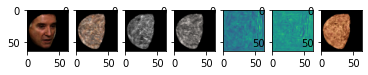

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


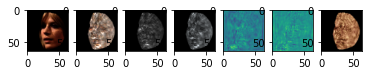

train average loss: 9.2575
b_loss: 6.348753959173337e-05, appearance_loss: 9.195614448657532, shading_loss: 0.001554805447296953, sparsity_loss: 0.06026175618171692
Epoch 1/599
Epoch 2/599
Epoch 3/599
Epoch 4/599
Epoch 5/599
Epoch 6/599
Epoch 7/599
Epoch 8/599
Epoch 9/599
Epoch 10/599
Epoch 11/599
Epoch 12/599
Epoch 13/599
Epoch 14/599
Epoch 15/599
Epoch 16/599
Epoch 17/599
Epoch 18/599
Epoch 19/599
Epoch 20/599
Epoch 21/599
Epoch 22/599
Epoch 23/599
Epoch 24/599
Epoch 25/599
Epoch 26/599
Epoch 27/599
Epoch 28/599
Epoch 29/599
Epoch 30/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


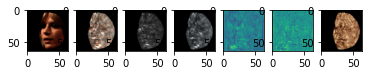

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


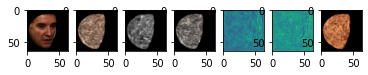

train average loss: 9.1555
b_loss: 0.00020802549261134118, appearance_loss: 9.09339895731454, shading_loss: 0.001554805447296953, sparsity_loss: 0.060413211584091187
Epoch 31/599
Epoch 32/599
Epoch 33/599
Epoch 34/599
Epoch 35/599
Epoch 36/599
Epoch 37/599
Epoch 38/599
Epoch 39/599
Epoch 40/599
Epoch 41/599
Epoch 42/599
Epoch 43/599
Epoch 44/599
Epoch 45/599
Epoch 46/599
Epoch 47/599
Epoch 48/599
Epoch 49/599
Epoch 50/599
Epoch 51/599
Epoch 52/599
Epoch 53/599
Epoch 54/599
Epoch 55/599
Epoch 56/599
Epoch 57/599
Epoch 58/599
Epoch 59/599
Epoch 60/599


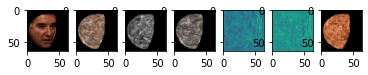

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


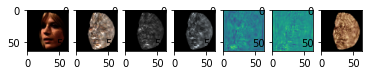

train average loss: 9.0282
b_loss: 0.00046185654355213046, appearance_loss: 8.965930331603108, shading_loss: 0.001554805447296953, sparsity_loss: 0.06048029661178589
Epoch 61/599
Epoch 62/599
Epoch 63/599
Epoch 64/599
Epoch 65/599
Epoch 66/599
Epoch 67/599
Epoch 68/599
Epoch 69/599
Epoch 70/599
Epoch 71/599
Epoch 72/599
Epoch 73/599
Epoch 74/599
Epoch 75/599
Epoch 76/599
Epoch 77/599
Epoch 78/599
Epoch 79/599
Epoch 80/599
Epoch 81/599
Epoch 82/599
Epoch 83/599
Epoch 84/599
Epoch 85/599
Epoch 86/599
Epoch 87/599
Epoch 88/599
Epoch 89/599
Epoch 90/599


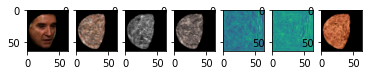

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


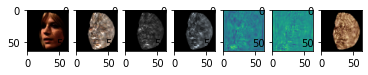

train average loss: 8.9218
b_loss: 0.0008786183316260576, appearance_loss: 8.858746719576295, shading_loss: 0.001554805447296953, sparsity_loss: 0.061040785163640976
Epoch 91/599
Epoch 92/599
Epoch 93/599
Epoch 94/599
Epoch 95/599
Epoch 96/599
Epoch 97/599
Epoch 98/599
Epoch 99/599
Epoch 100/599
Epoch 101/599
Epoch 102/599
Epoch 103/599
Epoch 104/599
Epoch 105/599
Epoch 106/599
Epoch 107/599
Epoch 108/599
Epoch 109/599
Epoch 110/599
Epoch 111/599
Epoch 112/599
Epoch 113/599
Epoch 114/599
Epoch 115/599
Epoch 116/599
Epoch 117/599
Epoch 118/599
Epoch 119/599
Epoch 120/599


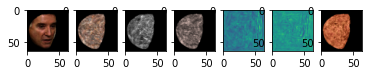

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


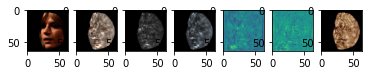

train average loss: 8.8590
b_loss: 0.0011400736402720213, appearance_loss: 8.795338444759317, shading_loss: 0.001554805447296953, sparsity_loss: 0.061516035348176956
Epoch 121/599
Epoch 122/599
Epoch 123/599
Epoch 124/599
Epoch 125/599
Epoch 126/599
Epoch 127/599
Epoch 128/599
Epoch 129/599
Epoch 130/599
Epoch 131/599
Epoch 132/599
Epoch 133/599
Epoch 134/599
Epoch 135/599
Epoch 136/599
Epoch 137/599
Epoch 138/599
Epoch 139/599
Epoch 140/599
Epoch 141/599
Epoch 142/599
Epoch 143/599
Epoch 144/599
Epoch 145/599
Epoch 146/599
Epoch 147/599
Epoch 148/599
Epoch 149/599
Epoch 150/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


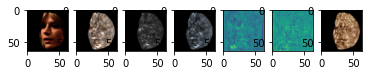

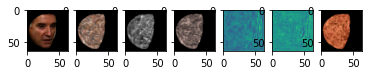

train average loss: 8.8366
b_loss: 0.0012347446754574776, appearance_loss: 8.772713333651616, shading_loss: 0.001554805447296953, sparsity_loss: 0.06173871085047722
Epoch 151/599
Epoch 152/599
Epoch 153/599
Epoch 154/599
Epoch 155/599
Epoch 156/599
Epoch 157/599
Epoch 158/599
Epoch 159/599
Epoch 160/599
Epoch 161/599
Epoch 162/599
Epoch 163/599
Epoch 164/599
Epoch 165/599
Epoch 166/599
Epoch 167/599
Epoch 168/599
Epoch 169/599
Epoch 170/599
Epoch 171/599
Epoch 172/599
Epoch 173/599
Epoch 174/599
Epoch 175/599
Epoch 176/599
Epoch 177/599
Epoch 178/599
Epoch 179/599
Epoch 180/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


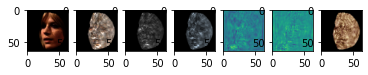

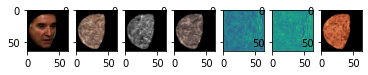

train average loss: 8.8201
b_loss: 0.0013191669713705778, appearance_loss: 8.755969701171344, shading_loss: 0.001554805447296953, sparsity_loss: 0.06191207841038704
Epoch 181/599
Epoch 182/599
Epoch 183/599
Epoch 184/599
Epoch 185/599
Epoch 186/599
Epoch 187/599
Epoch 188/599
Epoch 189/599
Epoch 190/599
Epoch 191/599
Epoch 192/599
Epoch 193/599
Epoch 194/599
Epoch 195/599
Epoch 196/599
Epoch 197/599
Epoch 198/599
Epoch 199/599
Epoch 200/599
Epoch 201/599
Epoch 202/599
Epoch 203/599
Epoch 204/599
Epoch 205/599
Epoch 206/599
Epoch 207/599
Epoch 208/599
Epoch 209/599
Epoch 210/599


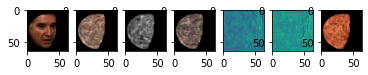

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


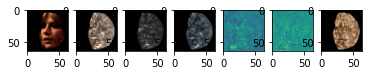

train average loss: 8.8080
b_loss: 0.0013772733509540558, appearance_loss: 8.743696510148453, shading_loss: 0.001554805447296953, sparsity_loss: 0.06205379217863083
Epoch 211/599
Epoch 212/599
Epoch 213/599
Epoch 214/599
Epoch 215/599
Epoch 216/599
Epoch 217/599
Epoch 218/599
Epoch 219/599
Epoch 220/599
Epoch 221/599
Epoch 222/599
Epoch 223/599
Epoch 224/599
Epoch 225/599
Epoch 226/599
Epoch 227/599
Epoch 228/599
Epoch 229/599
Epoch 230/599
Epoch 231/599
Epoch 232/599
Epoch 233/599
Epoch 234/599
Epoch 235/599
Epoch 236/599
Epoch 237/599
Epoch 238/599
Epoch 239/599
Epoch 240/599


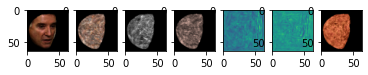

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


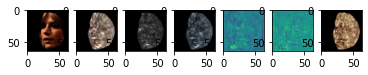

train average loss: 8.8009
b_loss: 0.0014099403051659465, appearance_loss: 8.736478517736792, shading_loss: 0.001554805447296953, sparsity_loss: 0.0621454194188118
Epoch 241/599
Epoch 242/599
Epoch 243/599
Epoch 244/599
Epoch 245/599
Epoch 246/599
Epoch 247/599
Epoch 248/599
Epoch 249/599
Epoch 250/599
Epoch 251/599
Epoch 252/599
Epoch 253/599
Epoch 254/599
Epoch 255/599
Epoch 256/599
Epoch 257/599
Epoch 258/599
Epoch 259/599
Epoch 260/599
Epoch 261/599
Epoch 262/599
Epoch 263/599
Epoch 264/599
Epoch 265/599
Epoch 266/599
Epoch 267/599
Epoch 268/599
Epoch 269/599
Epoch 270/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


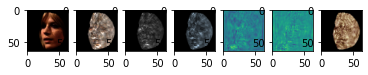

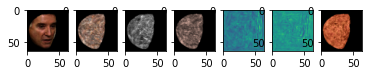

train average loss: 8.7939
b_loss: 0.001440542284399271, appearance_loss: 8.729399679472815, shading_loss: 0.001554805447296953, sparsity_loss: 0.06221041828393936
Epoch 271/599
Epoch 272/599
Epoch 273/599
Epoch 274/599
Epoch 275/599
Epoch 276/599
Epoch 277/599
Epoch 278/599
Epoch 279/599
Epoch 280/599
Epoch 281/599
Epoch 282/599
Epoch 283/599
Epoch 284/599
Epoch 285/599
Epoch 286/599
Epoch 287/599
Epoch 288/599
Epoch 289/599
Epoch 290/599
Epoch 291/599
Epoch 292/599
Epoch 293/599
Epoch 294/599
Epoch 295/599
Epoch 296/599
Epoch 297/599
Epoch 298/599
Epoch 299/599
Epoch 300/599


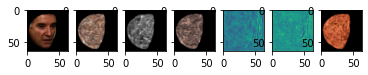

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


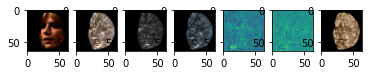

train average loss: 8.7859
b_loss: 0.001486523891799152, appearance_loss: 8.721321234349311, shading_loss: 0.001554805447296953, sparsity_loss: 0.062311287969350815
Epoch 301/599
Epoch 302/599
Epoch 303/599
Epoch 304/599
Epoch 305/599
Epoch 306/599
Epoch 307/599
Epoch 308/599
Epoch 309/599
Epoch 310/599
Epoch 311/599
Epoch 312/599
Epoch 313/599
Epoch 314/599
Epoch 315/599
Epoch 316/599
Epoch 317/599
Epoch 318/599
Epoch 319/599
Epoch 320/599
Epoch 321/599
Epoch 322/599
Epoch 323/599
Epoch 324/599
Epoch 325/599
Epoch 326/599
Epoch 327/599
Epoch 328/599
Epoch 329/599
Epoch 330/599


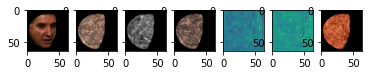

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


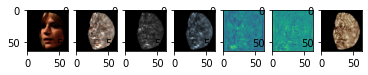

train average loss: 8.7799
b_loss: 0.0015197499888017774, appearance_loss: 8.715153594447367, shading_loss: 0.001554805447296953, sparsity_loss: 0.062383830547332764
Epoch 331/599
Epoch 332/599
Epoch 333/599
Epoch 334/599
Epoch 335/599
Epoch 336/599
Epoch 337/599
Epoch 338/599
Epoch 339/599
Epoch 340/599
Epoch 341/599
Epoch 342/599
Epoch 343/599
Epoch 344/599
Epoch 345/599
Epoch 346/599
Epoch 347/599
Epoch 348/599
Epoch 349/599
Epoch 350/599
Epoch 351/599
Epoch 352/599
Epoch 353/599
Epoch 354/599
Epoch 355/599
Epoch 356/599
Epoch 357/599
Epoch 358/599
Epoch 359/599
Epoch 360/599


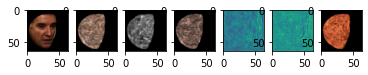

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


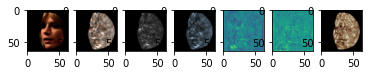

train average loss: 8.7735
b_loss: 0.0015489684883505106, appearance_loss: 8.70873837446446, shading_loss: 0.001554805447296953, sparsity_loss: 0.06244393438100815
Epoch 361/599
Epoch 362/599
Epoch 363/599
Epoch 364/599
Epoch 365/599
Epoch 366/599
Epoch 367/599
Epoch 368/599
Epoch 369/599
Epoch 370/599
Epoch 371/599
Epoch 372/599
Epoch 373/599
Epoch 374/599
Epoch 375/599
Epoch 376/599
Epoch 377/599
Epoch 378/599
Epoch 379/599
Epoch 380/599
Epoch 381/599
Epoch 382/599
Epoch 383/599
Epoch 384/599
Epoch 385/599
Epoch 386/599
Epoch 387/599
Epoch 388/599
Epoch 389/599
Epoch 390/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


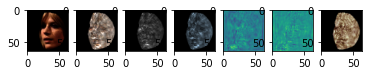

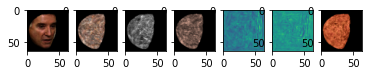

train average loss: 8.7676
b_loss: 0.001572008477523923, appearance_loss: 8.70276908422727, shading_loss: 0.001554805447296953, sparsity_loss: 0.062521792948246
Epoch 391/599
Epoch 392/599
Epoch 393/599
Epoch 394/599
Epoch 395/599
Epoch 396/599
Epoch 397/599
Epoch 398/599
Epoch 399/599
Epoch 400/599
Epoch 401/599
Epoch 402/599
Epoch 403/599
Epoch 404/599
Epoch 405/599
Epoch 406/599
Epoch 407/599
Epoch 408/599
Epoch 409/599
Epoch 410/599
Epoch 411/599
Epoch 412/599
Epoch 413/599
Epoch 414/599
Epoch 415/599
Epoch 416/599
Epoch 417/599
Epoch 418/599
Epoch 419/599
Epoch 420/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


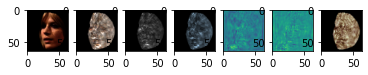

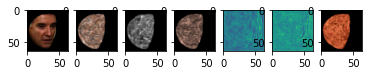

train average loss: 8.7622
b_loss: 0.001599205657839775, appearance_loss: 8.697239008910433, shading_loss: 0.001554805447296953, sparsity_loss: 0.06259584426879883
Epoch 421/599
Epoch 422/599
Epoch 423/599
Epoch 424/599
Epoch 425/599
Epoch 426/599
Epoch 427/599
Epoch 428/599
Epoch 429/599
Epoch 430/599
Epoch 431/599
Epoch 432/599
Epoch 433/599
Epoch 434/599
Epoch 435/599
Epoch 436/599
Epoch 437/599
Epoch 438/599
Epoch 439/599
Epoch 440/599
Epoch 441/599
Epoch 442/599
Epoch 443/599
Epoch 444/599
Epoch 445/599
Epoch 446/599
Epoch 447/599
Epoch 448/599
Epoch 449/599
Epoch 450/599


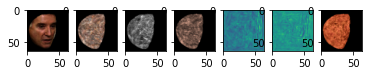

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


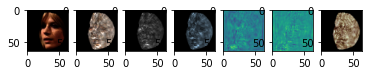

train average loss: 8.7547
b_loss: 0.0016322116134688258, appearance_loss: 8.689665239304366, shading_loss: 0.001554805447296953, sparsity_loss: 0.06266061216592789
Epoch 451/599
Epoch 452/599
Epoch 453/599
Epoch 454/599
Epoch 455/599
Epoch 456/599
Epoch 457/599
Epoch 458/599
Epoch 459/599
Epoch 460/599
Epoch 461/599
Epoch 462/599
Epoch 463/599
Epoch 464/599
Epoch 465/599
Epoch 466/599
Epoch 467/599
Epoch 468/599
Epoch 469/599
Epoch 470/599
Epoch 471/599
Epoch 472/599
Epoch 473/599
Epoch 474/599
Epoch 475/599
Epoch 476/599
Epoch 477/599
Epoch 478/599
Epoch 479/599
Epoch 480/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


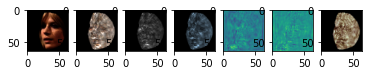

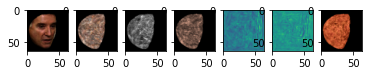

train average loss: 8.7486
b_loss: 0.001665816642343998, appearance_loss: 8.68350145625147, shading_loss: 0.001554805447296953, sparsity_loss: 0.06272199749946594
Epoch 481/599
Epoch 482/599
Epoch 483/599
Epoch 484/599
Epoch 485/599
Epoch 486/599
Epoch 487/599
Epoch 488/599
Epoch 489/599
Epoch 490/599
Epoch 491/599
Epoch 492/599
Epoch 493/599
Epoch 494/599
Epoch 495/599
Epoch 496/599
Epoch 497/599
Epoch 498/599
Epoch 499/599
Epoch 500/599
Epoch 501/599
Epoch 502/599
Epoch 503/599
Epoch 504/599
Epoch 505/599
Epoch 506/599
Epoch 507/599
Epoch 508/599
Epoch 509/599
Epoch 510/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


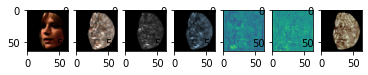

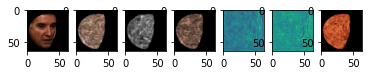

train average loss: 8.7426
b_loss: 0.0016934184823185205, appearance_loss: 8.677413669080074, shading_loss: 0.001554805447296953, sparsity_loss: 0.06275882571935654
Epoch 511/599
Epoch 512/599
Epoch 513/599
Epoch 514/599
Epoch 515/599
Epoch 516/599
Epoch 517/599
Epoch 518/599
Epoch 519/599
Epoch 520/599
Epoch 521/599
Epoch 522/599
Epoch 523/599
Epoch 524/599
Epoch 525/599
Epoch 526/599
Epoch 527/599
Epoch 528/599
Epoch 529/599
Epoch 530/599
Epoch 531/599
Epoch 532/599
Epoch 533/599
Epoch 534/599
Epoch 535/599
Epoch 536/599
Epoch 537/599
Epoch 538/599
Epoch 539/599
Epoch 540/599


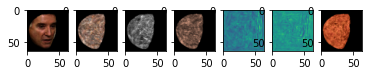

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


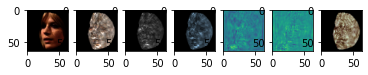

train average loss: 8.7373
b_loss: 0.001720255590043962, appearance_loss: 8.672046181372913, shading_loss: 0.001554805447296953, sparsity_loss: 0.06285827606916428
Epoch 541/599
Epoch 542/599
Epoch 543/599
Epoch 544/599
Epoch 545/599
Epoch 546/599
Epoch 547/599
Epoch 548/599
Epoch 549/599
Epoch 550/599
Epoch 551/599
Epoch 552/599
Epoch 553/599
Epoch 554/599
Epoch 555/599
Epoch 556/599
Epoch 557/599
Epoch 558/599
Epoch 559/599
Epoch 560/599
Epoch 561/599
Epoch 562/599
Epoch 563/599
Epoch 564/599
Epoch 565/599
Epoch 566/599
Epoch 567/599
Epoch 568/599
Epoch 569/599
Epoch 570/599


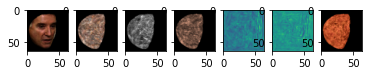

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


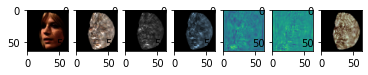

train average loss: 8.7324
b_loss: 0.0017426857957616448, appearance_loss: 8.667032863699216, shading_loss: 0.001554805447296953, sparsity_loss: 0.06290850043296814
Epoch 571/599
Epoch 572/599
Epoch 573/599
Epoch 574/599
Epoch 575/599
Epoch 576/599
Epoch 577/599
Epoch 578/599
Epoch 579/599
Epoch 580/599
Epoch 581/599
Epoch 582/599
Epoch 583/599
Epoch 584/599
Epoch 585/599
Epoch 586/599
Epoch 587/599
Epoch 588/599
Epoch 589/599
Epoch 590/599
Epoch 591/599
Epoch 592/599
Epoch 593/599
Epoch 594/599
Epoch 595/599
Epoch 596/599
Epoch 597/599
Epoch 598/599
Epoch 599/599


In [10]:
model = UNet(filters=[32,64,128,256,512], light_vector_size=15, n_class=4, b_size=2, add_double_conv=True)
optimizers = [torch.optim.Adam(model.parameters(), lr=learning_rate)]
display_condition = lambda phase, epoch: phase == "train" and epoch % 30 == 0
train_model(model, dataloaders, optimizers, output_path="/tmp", device=device, num_epochs=600, display_condition=display_condition)

To diagnose the problem, I replace the shading parameter with a grayscale version of the original image i.e. fixing the shading so that the network can easily copy this grayscale, add coloring, and reconstruct the original RGB as we are intentionally overfitting a small dataset below. This is done by passing `copy_shading=True` to UNet. You can visualize the grayscale image in the third column of each sample. Unfortunately this trick still does not help the reconstruction.

Epoch 0/599


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


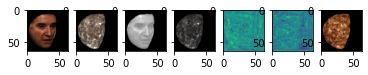

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


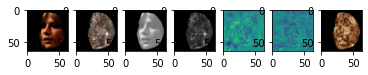

train average loss: 6.5503
b_loss: 2.6231338779325597e-05, appearance_loss: 6.489621810215595, shading_loss: 0.0005837952746333771, sparsity_loss: 0.06012513488531113
Epoch 1/599
Epoch 2/599
Epoch 3/599
Epoch 4/599
Epoch 5/599
Epoch 6/599
Epoch 7/599
Epoch 8/599
Epoch 9/599
Epoch 10/599
Epoch 11/599
Epoch 12/599
Epoch 13/599
Epoch 14/599
Epoch 15/599
Epoch 16/599
Epoch 17/599
Epoch 18/599
Epoch 19/599
Epoch 20/599
Epoch 21/599
Epoch 22/599
Epoch 23/599
Epoch 24/599
Epoch 25/599
Epoch 26/599
Epoch 27/599
Epoch 28/599
Epoch 29/599
Epoch 30/599
Epoch 31/599
Epoch 32/599
Epoch 33/599
Epoch 34/599
Epoch 35/599
Epoch 36/599
Epoch 37/599
Epoch 38/599
Epoch 39/599
Epoch 40/599
Epoch 41/599
Epoch 42/599
Epoch 43/599
Epoch 44/599
Epoch 45/599
Epoch 46/599
Epoch 47/599
Epoch 48/599
Epoch 49/599
Epoch 50/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


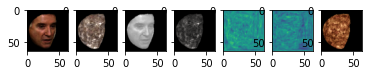

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


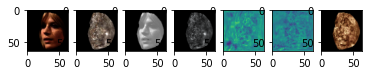

train average loss: 6.5041
b_loss: 0.0001077142806025222, appearance_loss: 6.443219912737195, shading_loss: 0.0005837952746333771, sparsity_loss: 0.06021617352962494
Epoch 51/599
Epoch 52/599
Epoch 53/599
Epoch 54/599
Epoch 55/599
Epoch 56/599
Epoch 57/599
Epoch 58/599
Epoch 59/599
Epoch 60/599
Epoch 61/599
Epoch 62/599
Epoch 63/599
Epoch 64/599
Epoch 65/599
Epoch 66/599
Epoch 67/599
Epoch 68/599
Epoch 69/599
Epoch 70/599
Epoch 71/599
Epoch 72/599
Epoch 73/599
Epoch 74/599
Epoch 75/599
Epoch 76/599
Epoch 77/599
Epoch 78/599
Epoch 79/599
Epoch 80/599
Epoch 81/599
Epoch 82/599
Epoch 83/599
Epoch 84/599
Epoch 85/599
Epoch 86/599
Epoch 87/599
Epoch 88/599
Epoch 89/599
Epoch 90/599
Epoch 91/599
Epoch 92/599
Epoch 93/599
Epoch 94/599
Epoch 95/599
Epoch 96/599
Epoch 97/599
Epoch 98/599
Epoch 99/599
Epoch 100/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


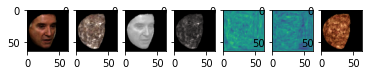

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


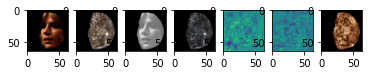

train average loss: 6.4241
b_loss: 0.0005750710843130946, appearance_loss: 6.362639275053756, shading_loss: 0.0005837952746333771, sparsity_loss: 0.060606375336647034
Epoch 101/599
Epoch 102/599
Epoch 103/599
Epoch 104/599
Epoch 105/599
Epoch 106/599
Epoch 107/599
Epoch 108/599
Epoch 109/599
Epoch 110/599
Epoch 111/599
Epoch 112/599
Epoch 113/599
Epoch 114/599
Epoch 115/599
Epoch 116/599
Epoch 117/599
Epoch 118/599
Epoch 119/599
Epoch 120/599
Epoch 121/599
Epoch 122/599
Epoch 123/599
Epoch 124/599
Epoch 125/599
Epoch 126/599
Epoch 127/599
Epoch 128/599
Epoch 129/599
Epoch 130/599
Epoch 131/599
Epoch 132/599
Epoch 133/599
Epoch 134/599
Epoch 135/599
Epoch 136/599
Epoch 137/599
Epoch 138/599
Epoch 139/599
Epoch 140/599
Epoch 141/599
Epoch 142/599
Epoch 143/599
Epoch 144/599
Epoch 145/599
Epoch 146/599
Epoch 147/599
Epoch 148/599
Epoch 149/599
Epoch 150/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


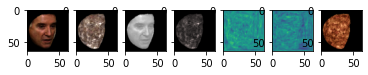

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


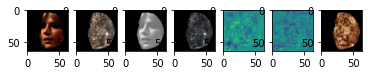

train average loss: 6.3894
b_loss: 0.0009170675766654313, appearance_loss: 6.327146665766213, shading_loss: 0.0005837952746333771, sparsity_loss: 0.061249542981386185
Epoch 151/599
Epoch 152/599
Epoch 153/599
Epoch 154/599
Epoch 155/599
Epoch 156/599
Epoch 157/599
Epoch 158/599
Epoch 159/599
Epoch 160/599
Epoch 161/599
Epoch 162/599
Epoch 163/599
Epoch 164/599
Epoch 165/599
Epoch 166/599
Epoch 167/599
Epoch 168/599
Epoch 169/599
Epoch 170/599
Epoch 171/599
Epoch 172/599
Epoch 173/599
Epoch 174/599
Epoch 175/599
Epoch 176/599
Epoch 177/599
Epoch 178/599
Epoch 179/599
Epoch 180/599
Epoch 181/599
Epoch 182/599
Epoch 183/599
Epoch 184/599
Epoch 185/599
Epoch 186/599
Epoch 187/599
Epoch 188/599
Epoch 189/599
Epoch 190/599
Epoch 191/599
Epoch 192/599
Epoch 193/599
Epoch 194/599
Epoch 195/599
Epoch 196/599
Epoch 197/599
Epoch 198/599
Epoch 199/599
Epoch 200/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


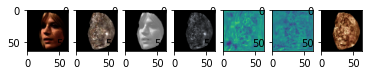

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


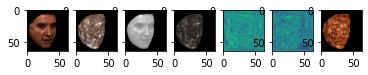

train average loss: 6.3752
b_loss: 0.001078691566362977, appearance_loss: 6.312525703744232, shading_loss: 0.0005837952746333771, sparsity_loss: 0.06152233108878136
Epoch 201/599
Epoch 202/599
Epoch 203/599
Epoch 204/599
Epoch 205/599
Epoch 206/599
Epoch 207/599
Epoch 208/599
Epoch 209/599
Epoch 210/599
Epoch 211/599
Epoch 212/599
Epoch 213/599
Epoch 214/599
Epoch 215/599
Epoch 216/599
Epoch 217/599
Epoch 218/599
Epoch 219/599
Epoch 220/599
Epoch 221/599
Epoch 222/599
Epoch 223/599
Epoch 224/599
Epoch 225/599
Epoch 226/599
Epoch 227/599
Epoch 228/599
Epoch 229/599
Epoch 230/599
Epoch 231/599
Epoch 232/599
Epoch 233/599
Epoch 234/599
Epoch 235/599
Epoch 236/599
Epoch 237/599
Epoch 238/599
Epoch 239/599
Epoch 240/599
Epoch 241/599
Epoch 242/599
Epoch 243/599
Epoch 244/599
Epoch 245/599
Epoch 246/599
Epoch 247/599
Epoch 248/599
Epoch 249/599
Epoch 250/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


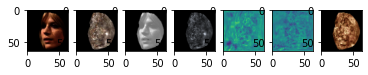

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


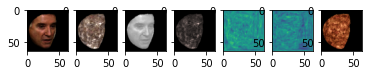

train average loss: 6.3676
b_loss: 0.0011593927629292011, appearance_loss: 6.304802782726797, shading_loss: 0.0005837952746333771, sparsity_loss: 0.061674948781728745
Epoch 251/599
Epoch 252/599
Epoch 253/599
Epoch 254/599
Epoch 255/599
Epoch 256/599
Epoch 257/599
Epoch 258/599
Epoch 259/599
Epoch 260/599
Epoch 261/599
Epoch 262/599
Epoch 263/599
Epoch 264/599
Epoch 265/599
Epoch 266/599
Epoch 267/599
Epoch 268/599
Epoch 269/599
Epoch 270/599
Epoch 271/599
Epoch 272/599
Epoch 273/599
Epoch 274/599
Epoch 275/599
Epoch 276/599
Epoch 277/599
Epoch 278/599
Epoch 279/599
Epoch 280/599
Epoch 281/599
Epoch 282/599
Epoch 283/599
Epoch 284/599
Epoch 285/599
Epoch 286/599
Epoch 287/599
Epoch 288/599
Epoch 289/599
Epoch 290/599
Epoch 291/599
Epoch 292/599
Epoch 293/599
Epoch 294/599
Epoch 295/599
Epoch 296/599
Epoch 297/599
Epoch 298/599
Epoch 299/599
Epoch 300/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


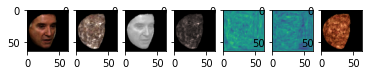

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


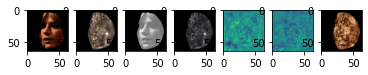

train average loss: 6.3594
b_loss: 0.0012779614189639688, appearance_loss: 6.296202408307222, shading_loss: 0.0005837952746333771, sparsity_loss: 0.06192675605416298
Epoch 301/599
Epoch 302/599
Epoch 303/599
Epoch 304/599
Epoch 305/599
Epoch 306/599
Epoch 307/599
Epoch 308/599
Epoch 309/599
Epoch 310/599
Epoch 311/599
Epoch 312/599
Epoch 313/599
Epoch 314/599
Epoch 315/599
Epoch 316/599
Epoch 317/599
Epoch 318/599
Epoch 319/599
Epoch 320/599
Epoch 321/599
Epoch 322/599
Epoch 323/599
Epoch 324/599
Epoch 325/599
Epoch 326/599
Epoch 327/599
Epoch 328/599
Epoch 329/599
Epoch 330/599
Epoch 331/599
Epoch 332/599
Epoch 333/599
Epoch 334/599
Epoch 335/599
Epoch 336/599
Epoch 337/599
Epoch 338/599
Epoch 339/599
Epoch 340/599
Epoch 341/599
Epoch 342/599
Epoch 343/599
Epoch 344/599
Epoch 345/599
Epoch 346/599
Epoch 347/599
Epoch 348/599
Epoch 349/599
Epoch 350/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


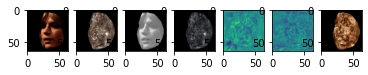

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


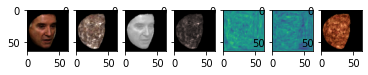

train average loss: 6.3535
b_loss: 0.0013455053558573127, appearance_loss: 6.290109682161927, shading_loss: 0.0005837952746333771, sparsity_loss: 0.062115300446748734
Epoch 351/599
Epoch 352/599
Epoch 353/599
Epoch 354/599
Epoch 355/599
Epoch 356/599
Epoch 357/599
Epoch 358/599
Epoch 359/599
Epoch 360/599
Epoch 361/599
Epoch 362/599
Epoch 363/599
Epoch 364/599
Epoch 365/599
Epoch 366/599
Epoch 367/599
Epoch 368/599
Epoch 369/599
Epoch 370/599
Epoch 371/599
Epoch 372/599
Epoch 373/599
Epoch 374/599
Epoch 375/599
Epoch 376/599
Epoch 377/599
Epoch 378/599
Epoch 379/599
Epoch 380/599
Epoch 381/599
Epoch 382/599
Epoch 383/599
Epoch 384/599
Epoch 385/599
Epoch 386/599
Epoch 387/599
Epoch 388/599
Epoch 389/599
Epoch 390/599
Epoch 391/599
Epoch 392/599
Epoch 393/599
Epoch 394/599
Epoch 395/599
Epoch 396/599
Epoch 397/599
Epoch 398/599
Epoch 399/599
Epoch 400/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


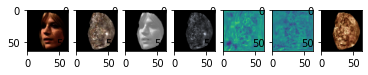

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


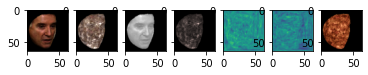

train average loss: 6.3476
b_loss: 0.0014273767592385411, appearance_loss: 6.283991466013125, shading_loss: 0.0005837952746333771, sparsity_loss: 0.06232084706425667
Epoch 401/599
Epoch 402/599
Epoch 403/599
Epoch 404/599
Epoch 405/599
Epoch 406/599
Epoch 407/599
Epoch 408/599
Epoch 409/599
Epoch 410/599
Epoch 411/599
Epoch 412/599
Epoch 413/599
Epoch 414/599
Epoch 415/599
Epoch 416/599
Epoch 417/599
Epoch 418/599
Epoch 419/599
Epoch 420/599
Epoch 421/599
Epoch 422/599
Epoch 423/599
Epoch 424/599
Epoch 425/599
Epoch 426/599
Epoch 427/599
Epoch 428/599
Epoch 429/599
Epoch 430/599
Epoch 431/599
Epoch 432/599
Epoch 433/599
Epoch 434/599
Epoch 435/599
Epoch 436/599
Epoch 437/599
Epoch 438/599
Epoch 439/599
Epoch 440/599
Epoch 441/599
Epoch 442/599
Epoch 443/599
Epoch 444/599
Epoch 445/599
Epoch 446/599
Epoch 447/599
Epoch 448/599
Epoch 449/599
Epoch 450/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


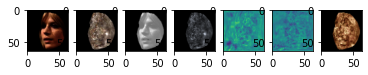

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


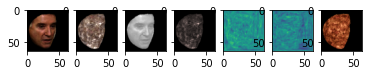

train average loss: 6.3428
b_loss: 0.0015049881767481565, appearance_loss: 6.278924948061386, shading_loss: 0.0005837952746333771, sparsity_loss: 0.06253533810377121
Epoch 451/599
Epoch 452/599
Epoch 453/599
Epoch 454/599
Epoch 455/599
Epoch 456/599
Epoch 457/599
Epoch 458/599
Epoch 459/599
Epoch 460/599
Epoch 461/599
Epoch 462/599
Epoch 463/599
Epoch 464/599
Epoch 465/599
Epoch 466/599
Epoch 467/599
Epoch 468/599
Epoch 469/599
Epoch 470/599
Epoch 471/599
Epoch 472/599
Epoch 473/599
Epoch 474/599
Epoch 475/599
Epoch 476/599
Epoch 477/599
Epoch 478/599
Epoch 479/599
Epoch 480/599
Epoch 481/599
Epoch 482/599
Epoch 483/599
Epoch 484/599
Epoch 485/599
Epoch 486/599
Epoch 487/599
Epoch 488/599
Epoch 489/599
Epoch 490/599
Epoch 491/599
Epoch 492/599
Epoch 493/599
Epoch 494/599
Epoch 495/599
Epoch 496/599
Epoch 497/599
Epoch 498/599
Epoch 499/599
Epoch 500/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


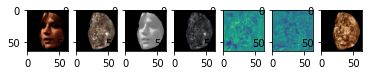

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


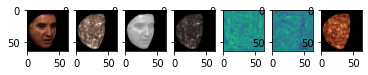

train average loss: 6.3380
b_loss: 0.0015697954222559929, appearance_loss: 6.273901458076105, shading_loss: 0.0005837952746333771, sparsity_loss: 0.06273896992206573
Epoch 501/599
Epoch 502/599
Epoch 503/599
Epoch 504/599
Epoch 505/599
Epoch 506/599
Epoch 507/599
Epoch 508/599
Epoch 509/599
Epoch 510/599
Epoch 511/599
Epoch 512/599
Epoch 513/599
Epoch 514/599
Epoch 515/599
Epoch 516/599
Epoch 517/599
Epoch 518/599
Epoch 519/599
Epoch 520/599
Epoch 521/599
Epoch 522/599
Epoch 523/599
Epoch 524/599
Epoch 525/599
Epoch 526/599
Epoch 527/599
Epoch 528/599
Epoch 529/599
Epoch 530/599
Epoch 531/599
Epoch 532/599
Epoch 533/599
Epoch 534/599
Epoch 535/599
Epoch 536/599
Epoch 537/599
Epoch 538/599
Epoch 539/599
Epoch 540/599
Epoch 541/599
Epoch 542/599
Epoch 543/599
Epoch 544/599
Epoch 545/599
Epoch 546/599
Epoch 547/599
Epoch 548/599
Epoch 549/599
Epoch 550/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


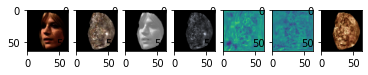

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


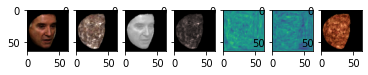

train average loss: 6.3337
b_loss: 0.001633683918043971, appearance_loss: 6.269342893667541, shading_loss: 0.0005837952746333771, sparsity_loss: 0.0629529058933258
Epoch 551/599
Epoch 552/599
Epoch 553/599
Epoch 554/599
Epoch 555/599
Epoch 556/599
Epoch 557/599
Epoch 558/599
Epoch 559/599
Epoch 560/599
Epoch 561/599
Epoch 562/599
Epoch 563/599
Epoch 564/599
Epoch 565/599
Epoch 566/599
Epoch 567/599
Epoch 568/599
Epoch 569/599
Epoch 570/599
Epoch 571/599
Epoch 572/599
Epoch 573/599
Epoch 574/599
Epoch 575/599
Epoch 576/599
Epoch 577/599
Epoch 578/599
Epoch 579/599
Epoch 580/599
Epoch 581/599
Epoch 582/599
Epoch 583/599
Epoch 584/599
Epoch 585/599
Epoch 586/599
Epoch 587/599
Epoch 588/599
Epoch 589/599
Epoch 590/599
Epoch 591/599
Epoch 592/599
Epoch 593/599
Epoch 594/599
Epoch 595/599
Epoch 596/599
Epoch 597/599
Epoch 598/599
Epoch 599/599


In [11]:
model = UNet(filters=[32,64,128,256,512], light_vector_size=15, n_class=4, b_size=2, add_double_conv=True, copy_shading=True)
optimizers = [torch.optim.Adam(model.parameters(), lr=learning_rate)]
display_condition = lambda phase, epoch: phase == "train" and epoch % 50 == 0
train_model(model, dataloaders, optimizers, output_path="/tmp", device=device, num_epochs=600, display_condition=display_condition)

# ISET dataset & older paper to reproduce Table 1

To reproduce the results in Table 1, we need to reproduce [the authors' older paper (Smith 2019)](https://arxiv.org/pdf/1902.06557.pdf) since Table 1 is the error difference between the results in this older paper versus BioFaceNet. Now, the authors use the ISET database instead of CelebA since ISET contains spectrometer measurements of faces. ISET does not contain any real RGB images.

In (Smith 2019), they make the same physics model assumptions about haemoglobin, melanin, specularity, and diffuse masks but instead of using a deep learning network to learn them, they use least squares minimization to estimate them directly.

It is hard to write the least squares minimization (see Eq. 3 in (Smith 2019)) in closed form. Assuming the problem is convex, one solution is to minimize iteratively with SGD until convergence and then export these optimal torch weights.

Notes:

- The paper assumes "scene illumination is spectrally uniform" and I interpret that as `e` being uniform.

- The paper uses "mean camera spectral spectral sensitivity" so I assume it's safe to use the top two eigenvalues to represent the camera parameters `b` which is the same camera model assumption in BioFaceNet.

In [12]:
class ISETDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_root_path="ISET", small=False):
    self.small = small
    self.image_files, self.param_files = self._read_dataset(dataset_root_path)

  def _read_dataset(self, dataset_root_path):
    """
    Read the matfiles of ISET Faces and perform basic validation.
    The first matfile has:
      mcCOEF (1155, 888, 6) shaped
      basis[0][0][0] (160, 6) shaped
      comment (1,) shaped
      imgMean (1, 160) shaped
      illuminant[0][0][0] == "D65", illuminant[0][0][1] == "illuminant"
      illuminant[0][0][2][0][0][0] (1, 160) shaped
      illuminant[0][0][3][0][0][0] (1394, 984, 160) shaped
      fov (1, 1) shaped
      dist (1, 1) shaped
      name (1,) shaped
      params contains arbitrary params from the HySpex line-scan imaging spectrometer
    """
    files = [f for f in os.listdir(dataset_root_path)]
    image_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in [f"HiResFemale{i}.mat" for i in range(1, 14)] + [f"HiResMale{i}.mat" for i in range(1, 13)]]
    param_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in [f"HiResFemale{i}_Params.mat" for i in range(1, 14)] + [f"HiResMale{i}_Params.mat" for i in range(1, 13)]]
    for image_file in image_files: assert os.path.exists(image_file), f"{image_file} not found" 
    for param_file in param_files: assert os.path.exists(param_file), f"{param_file} not found" 
    assert len(image_files) == len(param_files), "number of image mat files and the number of param mat files mismatch"
    print(image_files)
    print(param_files)
    return image_files, param_files

  def __len__(self):
    return 1 if self.small else len(image_files)

  def __getitem__(self, idx):
    image = scipy.io.loadmat(self.image_files[idx])
    param = scipy.io.loadmat(self.param_files[idx])
    return {"spectrum": image["mcCOEF"], **{key: value for key, value in image.items() if key != "mcCOEF"}}

def displayISETSample(sampleNo):
  item = ISETDataset(dataset_root_path="/tmp/ISET")[sampleNo]
  plt.figure() 
  plt.imshow(item["spectrum"][...,2])
  print(item["spectrum"].shape)

One sample from the ISET dataset:

['/tmp/ISET/HiResFemale1.mat', '/tmp/ISET/HiResFemale2.mat', '/tmp/ISET/HiResFemale3.mat', '/tmp/ISET/HiResFemale4.mat', '/tmp/ISET/HiResFemale5.mat', '/tmp/ISET/HiResFemale6.mat', '/tmp/ISET/HiResFemale7.mat', '/tmp/ISET/HiResFemale8.mat', '/tmp/ISET/HiResFemale9.mat', '/tmp/ISET/HiResFemale10.mat', '/tmp/ISET/HiResFemale11.mat', '/tmp/ISET/HiResFemale12.mat', '/tmp/ISET/HiResFemale13.mat', '/tmp/ISET/HiResMale1.mat', '/tmp/ISET/HiResMale2.mat', '/tmp/ISET/HiResMale3.mat', '/tmp/ISET/HiResMale4.mat', '/tmp/ISET/HiResMale5.mat', '/tmp/ISET/HiResMale6.mat', '/tmp/ISET/HiResMale7.mat', '/tmp/ISET/HiResMale8.mat', '/tmp/ISET/HiResMale9.mat', '/tmp/ISET/HiResMale10.mat', '/tmp/ISET/HiResMale11.mat', '/tmp/ISET/HiResMale12.mat']
['/tmp/ISET/HiResFemale1_Params.mat', '/tmp/ISET/HiResFemale2_Params.mat', '/tmp/ISET/HiResFemale3_Params.mat', '/tmp/ISET/HiResFemale4_Params.mat', '/tmp/ISET/HiResFemale5_Params.mat', '/tmp/ISET/HiResFemale6_Params.mat', '/tmp/ISET/HiResFemale7_Params.mat', '/tmp/

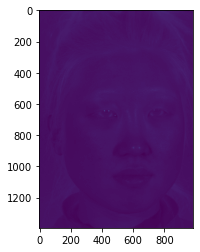

In [13]:
displayISETSample(0)

Normally, the authors exponentiate the shading and diffuse in order to make them nonnegative. However, this causes the losses to overshoot to NaN, so I use ReLU to drive the gradients instead.

['/tmp/ISET/HiResFemale1.mat', '/tmp/ISET/HiResFemale2.mat', '/tmp/ISET/HiResFemale3.mat', '/tmp/ISET/HiResFemale4.mat', '/tmp/ISET/HiResFemale5.mat', '/tmp/ISET/HiResFemale6.mat', '/tmp/ISET/HiResFemale7.mat', '/tmp/ISET/HiResFemale8.mat', '/tmp/ISET/HiResFemale9.mat', '/tmp/ISET/HiResFemale10.mat', '/tmp/ISET/HiResFemale11.mat', '/tmp/ISET/HiResFemale12.mat', '/tmp/ISET/HiResFemale13.mat', '/tmp/ISET/HiResMale1.mat', '/tmp/ISET/HiResMale2.mat', '/tmp/ISET/HiResMale3.mat', '/tmp/ISET/HiResMale4.mat', '/tmp/ISET/HiResMale5.mat', '/tmp/ISET/HiResMale6.mat', '/tmp/ISET/HiResMale7.mat', '/tmp/ISET/HiResMale8.mat', '/tmp/ISET/HiResMale9.mat', '/tmp/ISET/HiResMale10.mat', '/tmp/ISET/HiResMale11.mat', '/tmp/ISET/HiResMale12.mat']
['/tmp/ISET/HiResFemale1_Params.mat', '/tmp/ISET/HiResFemale2_Params.mat', '/tmp/ISET/HiResFemale3_Params.mat', '/tmp/ISET/HiResFemale4_Params.mat', '/tmp/ISET/HiResFemale5_Params.mat', '/tmp/ISET/HiResFemale6_Params.mat', '/tmp/ISET/HiResFemale7_Params.mat', '/tmp/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18 [2.82485649e-02 1.00270722e-02 5.31646326e-03 1.96436334e-03
 1.53850674e-03 8.68528901e-04 2.59307210e-04 9.73330595e-05
 5.44438850e-05 3.59661168e-05 5.89782795e-06 5.35926997e-06
 2.99975604e-06 1.76375480e-08 8.46885862e-09 1.01585571e-19
 3.68345268e-21 4.64057506e-19]
(18, 2) (18,) (18,)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


loss 1.6474329302373748e+34
loss 1.2544340438495739e+34
loss 1.2384016004104595e+34
loss 1.235278109523717e+34
loss 1.2344981017207863e+34
loss 1.2342378172470552e+34
loss 1.2341389693814797e+34
loss 1.234099441073076e+34
loss 1.2340822451400836e+34
loss 1.2340734477783235e+34
loss 1.2340680093274975e+34
loss 1.2340641832344483e+34
loss 1.2340613043619728e+34


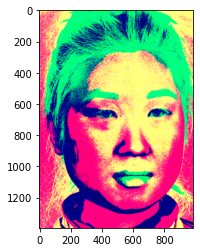

In [14]:
def decompose_multispectral(multispectral_obs, display_condition=lambda i:True):
  wavelength = 6
  # multispectral_obs has shape (1, 6, H, W)
  _, _, H, W = multispectral_obs.shape
  PC, mu, EV = camera_sensitivity_pca(np.array(list(scipy.io.loadmat("BioFaces/util/rgbCMF.mat")["rgbCMF"][0]))[:,[1,7,13,19,25,31],:], wavelength)
  PC, mu, EV = torch.from_numpy(PC).float(), torch.from_numpy(mu).float(), torch.from_numpy(EV).float()

  class ModelFitting(nn.Module):
    def __init__(self):
      super(ModelFitting, self).__init__()
      self.shading_weights = torch.nn.Linear(in_features=1, out_features=H*W, bias=False)
      self.specularities_weights = torch.nn.Linear(in_features=1, out_features=3*H*W, bias=False)
      self.f_mel_weights = torch.nn.Linear(in_features=1, out_features=H*W, bias=False)
      self.f_blood_weights = torch.nn.Linear(in_features=1, out_features=H*W, bias=False)
    
    def scale_shading(self, shading):
      return F.relu(shading) # torch.exp(shading)
    
    def scale_specularities(self, specularities):
      return F.relu(specularities) # torch.exp(specularities)

    def scale_f_mel(self, f_mel):
      return (43/100 - 1.3/100) * torch.sigmoid(f_mel) + 1.3/100

    def scale_f_blood(self, f_blood):
      return (7/100 - 2/100) * torch.sigmoid(f_blood) + 2/100

    def forward(self, x):
      shading = self.scale_shading(self.shading_weights(x).reshape(1, 1, H, W))
      specularities = self.scale_specularities(self.specularities_weights(x).reshape(1, 3, H, W))
      f_mel = self.scale_f_mel(self.f_mel_weights(x).reshape(1, 1, H, W))
      f_blood = self.scale_f_blood(self.f_blood_weights(x).reshape(1, 1, H, W))
      e = torch.ones(1, wavelength) / wavelength # the paper says "scene illumination is spectrally uniform" so I assume this means e is uniform.
      b = EV.reshape(1, -1) # the paper uses "mean camera spectral spectral sensitivity" so it's safe to use the top two eigenvalues like we did in BioFaceNet.
      s_r, s_g, s_b = camera_model(mu, PC, b, wavelength)
      # discretizing new_skin_color by subsampling equally-spaced 6 wavelengths from the original 33-wavelength discretization.
      r_total = bio_to_spectral_ref(f_mel, f_blood, new_skin_color[:1,[1,7,13,19,25,31],...])
      raw_appearance, diffuse_albedo = image_formation(r_total, s_r, s_g, s_b, e, specularities, shading)
      return raw_appearance # (B, 3, H, W)

  model = ModelFitting()
  lr = 1e+16
  optimizers = [torch.optim.Adam(model.parameters(), lr=lr)]
  lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizers[0], gamma=0.999)

  prev_loss, loss = 0, 0
  # Make the multispectral input tricolor by averaging close channels so we can compare with raw_appearance
  multispectral_obs = np.concatenate((multispectral_obs[:,:2].mean(axis=1, keepdims=True), multispectral_obs[:,2:4].mean(axis=1, keepdims=True), multispectral_obs[:,4:].mean(axis=1, keepdims=True)), axis=1)
  plt.imshow(np.moveaxis(multispectral_obs[0], 0, -1))
  multispectral_obs = torch.from_numpy(multispectral_obs)
  i = 0
  while prev_loss - loss > 10 * lr or i < 2:
    prev_loss = loss
    for optimizer in optimizers: optimizer.zero_grad()
    outputs = model(torch.ones(1, 1))
    loss = torch.sum((outputs - multispectral_obs)**2) / (outputs.shape[-1] * outputs.shape[-2]) # * actual_masks
    loss.backward()
    loss = loss.item()
    if display_condition(i):
      print("loss", loss)
    for optimizer in optimizers: optimizer.step()
    if i % 1000 == 0: 
      lr_scheduler.step()
    i += 1      
  i_d, i_s, f_mel, f_blood = model.shading_weights.weight.data, model.specularities_weights.weight.data, model.f_mel_weights.weight.data, model.f_blood_weights.weight.data
  return model.scale_shading(i_d), model.scale_specularities(i_s), model.scale_f_mel(f_mel), model.scale_f_blood(f_blood)

def table_1_pipeline():
  for item in ISETDataset(dataset_root_path="/tmp/ISET"):
    i_d, i_s, f_mel, f_blood = decompose_multispectral(np.moveaxis(item["spectrum"], -1, 0)[np.newaxis,...], display_condition=lambda i: i % 100 == 0)
    break
  return i_d, i_s, f_mel, f_blood
  
i_d, i_s, f_mel, f_blood = table_1_pipeline()

The decomposition results are below.

Although the results appear far from the actual diffuse, specular, melanin, and haemoglobin maps, this optimization procedure appears to have recovered some meaningful output. This also could mean there is no major error in the PyTorch implementation of the `camera_model`, `bio_to_spectral_ref`, and `image_formation` methods which are also used in BioFaceNet.

If the BioFaceNet model worked, we would have D65-lighted the spectrums to produce an RGB image and passed that into BioFaceNet, comparing the maps below with those obtained from BioFaceNet. Taking the RMSE of the image differences would reproduce the second row of Table 1 in the paper.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


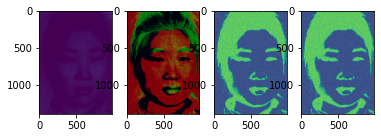

In [15]:
plt.figure()
plt.subplot(1, 4, 1)
plt.imshow(i_d.cpu().detach().numpy().reshape(1394, 984))
plt.subplot(1, 4, 2)
plt.imshow(np.moveaxis(i_s.cpu().detach().numpy().reshape(3, 1394, 984), 0, -1))
plt.subplot(1, 4, 3)
plt.imshow(f_mel.cpu().detach().numpy().reshape(1394, 984))
plt.subplot(1, 4, 4)
plt.imshow(f_blood.cpu().detach().numpy().reshape(1394, 984))

The same images as above but bigger:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


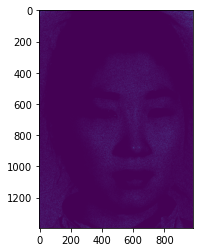

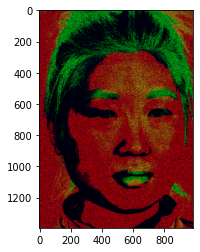

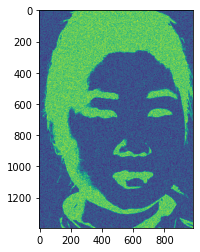

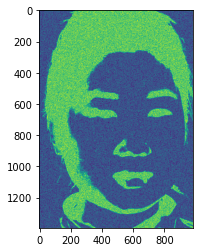

In [16]:
plt.imshow(i_d.cpu().detach().numpy().reshape(1394, 984))
plt.figure()
plt.imshow(np.moveaxis(i_s.cpu().detach().numpy().reshape(3, 1394, 984), 0, -1))
plt.figure()
plt.imshow(f_mel.cpu().detach().numpy().reshape(1394, 984))
plt.figure()
plt.imshow(f_blood.cpu().detach().numpy().reshape(1394, 984))

# Conclusion

The actual subset of the data the authors used is unclear, as they read from a matfile which is not present in the GitHub repo. When describing their CelebA data in the BioFaceNet paper, the authors cite a paper whose augmented CelebA dataset is on Google Drive (including parameters needed to compute shading), which is the one used in this reimplementation. It wouldn’t be possible to use the official CelebA data since there are no shading/harmonics parameters in it. If the authors obtained their shading data differently, this may have a large impact on why the results are not the same. Moreover, there are some potential overfitting issues about the pseudo-ground truth data mentioned in the first section here.

The authors’ older paper based on least squares minimization appears promising, and more work on it could shed light on why BioFaceNet doesn’t converge.